In [17]:
# --- Bu blok tensorflow importundan ÖNCE gelmeli ---
import os, logging, warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 0=hepsi, 1=INFO, 2=WARNING, 3=ERROR
# (İsteğe bağlı) oneDNN uyarıları çoksa:
# os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Abseil ve python warnings için:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
warnings.filterwarnings("ignore", module="tensorflow")
warnings.filterwarnings("ignore", category=UserWarning, module="absl")

import tensorflow as tf
tf.get_logger().setLevel("ERROR")
logging.getLogger("tensorflow").setLevel(logging.ERROR)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
# -----------------------------
# 1) VERIYI AL VE TEMEL ISLE
# -----------------------------
# Neden? Keras hazır CIFAR-10 sağlar; x'i 0–1 ölçeğine getiririz -> sayısal stabilite.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

In [20]:
# CIFAR-10 sınıf adları (raporlama için)
CLASS_NAMES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [21]:
# -----------------------------
# 2) NORMALIZASYON (SABIT MEAN/STD)
# -----------------------------
# Neden sabit? CIFAR-10 için literatürde kabul görmüş ort/std var; deterministik ve "adapt" hatası yok.
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)
norm_layer = layers.Normalization(
    mean=list(MEAN),
    variance=[s**2 for s in STD],
    axis=-1
)
# DİKKAT: mean/variance verdik -> adapt() çağırmıyoruz!

In [22]:
# -----------------------------
# 3) DATA AUGMENTATION (SADECE TRAIN)
# -----------------------------
# Neden? Görüntüleri hafifçe çeşitlendirerek overfit’i düşürür, genellemeyi artırır.
# CIFAR küçük (32x32) olduğu için oranları küçük tutuyoruz.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation")

In [23]:
# -----------------------------
# 4) MODEL MIMARISI
# -----------------------------
# Neden Conv-BN-ReLU + L2?
# - BN: Öğrenmeyi stabilize eder, daha yüksek LR'larda dahi güvenli.
# - L2(=weight decay): Aşırı öğrenmeyi engelleyerek genellemeyi artırır.
wd = 1e-4  # weight decay katsayısı

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

inputs = layers.Input(shape=(32,32,3))

# Sıra: (Rescaling zaten yaptık) -> Normalization -> Augmentation (train'de aktif)
x = norm_layer(inputs)                             # 0–1 veride sabit MEAN/STD ile normalize
x = data_augmentation(x, training=True)            # sadece eğitimde etkili

# Özellik çıkarımı (derinliği "genişlik" ile artırıyoruz)
x = conv_block(x, 32);  x = conv_block(x, 32);  x = layers.MaxPooling2D()(x)
x = conv_block(x, 64);  x = conv_block(x, 64);  x = layers.MaxPooling2D()(x)
x = conv_block(x, 128); x = conv_block(x, 128)

# Klasik "Flatten + Dense" yerine GAP (GlobalAveragePooling) -> daha az parametre & daha iyi genelleme
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)  # Neden? Üst katmanlarda overfit'i azaltır.

outputs = layers.Dense(10, activation="softmax")(x)
model = models.Model(inputs, outputs, name="cifar10_cnn_bn_l2")

model.summary()

Model: "cifar10_cnn_bn_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 3)        0         
 ion)                                                            
                                                                 
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        864       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 32, 32, 32)  

In [24]:
# --- Öğrenme oranı planı aynı kalsın ---
batch_size = 128
steps_per_epoch = x_train.shape[0] // batch_size
lr_schedule = optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=steps_per_epoch * 40
)

wd = 1e-4  # weight decay katsayısı (katmanlarda L2 de var)

# --- AdamW'yi bul: keras>=3, sonra experimental, sonra tfa; en sonda Adam fallback ---
AdamW = None
try:
    # Keras 3 yolu (TF 2.16+ ile gelir)
    from keras.optimizers import AdamW as KerasAdamW
    AdamW = KerasAdamW
except Exception:
    try:
        # TF 2.11–2.15 civarı
        from tensorflow.keras.optimizers.experimental import AdamW as ExpAdamW
        AdamW = ExpAdamW
    except Exception:
        try:
            # TensorFlow Addons (pip install tensorflow-addons)
            from tensorflow_addons.optimizers import AdamW as TFAAdamW
            AdamW = TFAAdamW
        except Exception:
            AdamW = None

if AdamW is not None:
    # AdamW (decoupled weight decay)
    opt = AdamW(learning_rate=lr_schedule, weight_decay=wd)
else:
    # Fallback: klasik Adam (weight decay yok; ama katmanlardaki L2 zaten aktif)
    opt = optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()  # label_smoothing olmadan
model.compile(optimizer=opt, loss=loss_fn, metrics=["accuracy"])



In [25]:
# -----------------------------
# 6) VALIDATION AYIRMA + CALLBACKS
# -----------------------------
# Neden validation_split?
# - Eğitim setinin %10'unu valid olarak ayırıp hyperparametre seçimini orada izleriz.
# Neden EarlyStopping + ModelCheckpoint?
# - Val metrik iyileşmeyi bıraktığında erken durdurup en iyi ağırlıkları geri alır.
# - En iyi modeli diske yazar; eğitim sonunda onu kullanırız.
es = callbacks.EarlyStopping(
    monitor="val_accuracy", mode="max", patience=8, restore_best_weights=True, verbose=1
)
ckpt = callbacks.ModelCheckpoint(
    "cifar10_cnn_aug_best.keras", monitor="val_accuracy",
    mode="max", save_best_only=True, verbose=1
)

In [26]:
# -----------------------------
# 7) EĞITIM
# -----------------------------
history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=40,
    batch_size=batch_size,
    callbacks=[es, ckpt],
    verbose=1
)

Epoch 1/40
352/352 [==============================] - ETA: 0s - loss: 1.7334 - accuracy: 0.3826   
Epoch 1: val_accuracy improved from -inf to 0.28260, saving model to cifar10_cnn_aug_best.keras
352/352 [==============================] - 154s 416ms/step - loss: 1.7334 - accuracy: 0.3826 - val_loss: 2.1027 - val_accuracy: 0.2826
Epoch 2/40
352/352 [==============================] - ETA: 0s - loss: 1.4656 - accuracy: 0.4866  
Epoch 2: val_accuracy improved from 0.28260 to 0.43120, saving model to cifar10_cnn_aug_best.keras
352/352 [==============================] - 160s 455ms/step - loss: 1.4656 - accuracy: 0.4866 - val_loss: 1.6813 - val_accuracy: 0.4312
Epoch 3/40
352/352 [==============================] - ETA: 0s - loss: 1.3550 - accuracy: 0.5326  
Epoch 3: val_accuracy improved from 0.43120 to 0.52040, saving model to cifar10_cnn_aug_best.keras
352/352 [==============================] - 155s 441ms/step - loss: 1.3550 - accuracy: 0.5326 - val_loss: 1.3723 - val_accuracy: 0.5204
Epoch 

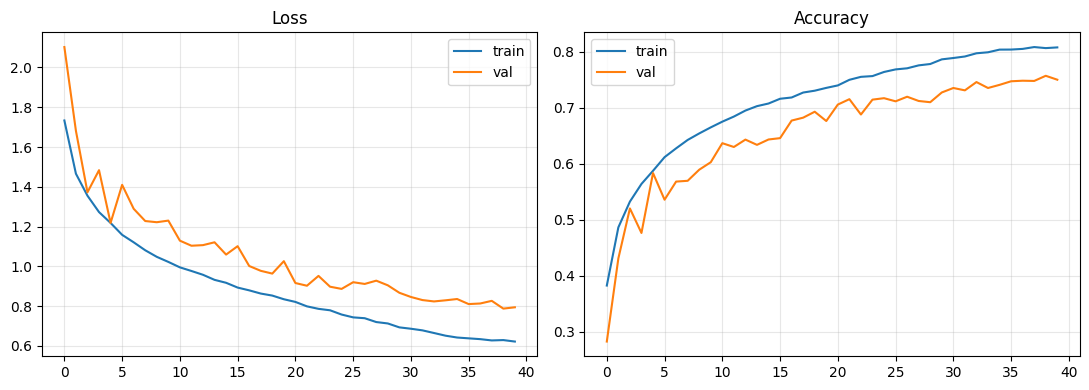

In [27]:
# -----------------------------
# 8) EĞITIM EĞRILERI (ANALIZ)
# -----------------------------
hist = history.history
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(hist["loss"], label="train"); plt.plot(hist["val_loss"], label="val")
plt.title("Loss"); plt.legend(); plt.grid(alpha=0.3)
plt.subplot(1,2,2)
plt.plot(hist["accuracy"], label="train"); plt.plot(hist["val_accuracy"], label="val")
plt.title("Accuracy"); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

In [28]:
# -----------------------------
# 9) TEST DEGERLENDIRME
# -----------------------------
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"[TEST] loss={test_loss:.4f} acc={test_acc:.4f}")

# Karışıklık matrisi & rapor (örnek)
y_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=CLASS_NAMES))


[TEST] loss=0.8370 acc=0.7458

Classification Report:
               precision    recall  f1-score   support

    airplane       0.82      0.78      0.80      1000
  automobile       0.85      0.83      0.84      1000
        bird       0.72      0.64      0.68      1000
         cat       0.61      0.56      0.58      1000
        deer       0.68      0.74      0.71      1000
         dog       0.70      0.65      0.68      1000
        frog       0.75      0.82      0.79      1000
       horse       0.77      0.82      0.79      1000
        ship       0.84      0.83      0.84      1000
       truck       0.77      0.83      0.80      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [29]:
# -----------------------------
# 10) MODEL KAYDET / YÜKLE
# -----------------------------
# Neden kaydediyoruz?
# - Üretimde tekrar kullanılabilirlik, deney tekrarlanabilirliği, "en iyi" anın korunması için.
model.save("cifar10_cnn_aug_final.keras")  # son ağırlıklar
best_model = tf.keras.models.load_model("cifar10_cnn_aug_best.keras")
best_test_acc = best_model.evaluate(x_test, y_test, verbose=0)[1]
print(f"[BEST-CHECKPOINT] test_acc={best_test_acc:.4f}")

[BEST-CHECKPOINT] test_acc=0.7510


In [30]:
# -----------------------------
# 11) TEK GÖRSEL TAHMIN ÖRNEĞI (opsiyonel)
# -----------------------------
# Neden? Üretimde tek örnek için de aynı ön-işleme ve normalize akışını uygularız.
def predict_single(image_np_hwc):
    # image_np_hwc: (H,W,C) [0..255] veya [0..1]
    x = image_np_hwc.astype("float32")
    if x.max() > 1.0:  # 0-1'e indir
        x = x / 255.0
    x = np.expand_dims(x, 0)  # (1, H, W, C)
    # Ayni pipeline: norm_layer modelin içinde zaten var -> direkt model.predict
    proba = best_model.predict(x, verbose=0)
    cls = int(np.argmax(proba, axis=1)[0])
    return CLASS_NAMES[cls], float(np.max(proba))

In [31]:
# örnek kullanım:
pred_label, pred_conf = predict_single(x_test[0]*255.0)  # x_test zaten 0-1'de
print("Pred:", pred_label, "Conf:", round(pred_conf, 3))

Pred: cat Conf: 0.659


In [32]:
from PIL import Image
import numpy as np

def predict_file(path, target_size=(32,32)):
    img = Image.open(path).convert("RGB").resize(target_size, Image.BILINEAR)
    x = np.array(img).astype("float32")/255.0      # 0-1
    x = np.expand_dims(x, 0)                       # (1,32,32,3)
    proba = best_model.predict(x, verbose=0)[0]    # (10,)
    cls   = int(np.argmax(proba))
    conf  = float(np.max(proba))
    # Top-3 istersen:
    top3_idx = np.argsort(proba)[-3:][::-1]
    top3 = [(CLASS_NAMES[i], float(proba[i])) for i in top3_idx]
    return CLASS_NAMES[cls], conf, top3

In [33]:
# Örnek kullanım:
# pred, conf, top3 = predict_file("some_image.jpg")
# print("Pred:", pred, "| Conf:", round(conf,3), "| Top-3:", [(c, round(p,3)) for c,p in top3])

harika—CIFAR-10 için **baştan sona, çalışır** bir eğitim betiğini; her adımın **ne yaptığını** ve **neden yaptığımızı** anlatarak veriyorum.
Aşağıdaki kod, senin yaşadığın `Normalization(...); norm.adapt(...)` çakışmasını **statik istatistik** kullanarak çözer.

---

# 0) Genel hedef ve tasarım

* **Amaç:** CIFAR-10’da sağlam bir temel CNN kurup **genelleme başarımını** artırmak.
* **Temel ilkeler:**

  * **Doğru ön-işleme:** 0–1 ölçeği + **CIFAR-10 mean/std** ile normalizasyon.
  * **Sadece eğitimde augmentasyon:** Overfit’i azaltmak için küçük dönüşümler.
  * **Conv-BN-ReLU blokları + L2 (weight decay):** Daha stabil ve iyi genelleme.
  * **Uygun LR planı + erken durdurma:** Hızlı yakınsama, gereksiz epoch yok.
  * **Label smoothing:** Çok sınıflıda hedefleri yumuşatarak aşırı güveni kırar.

---

# 2) Adımların “Neden” Özeti

1. **0–1 ölçek:** Derin ağlarda sayısal stabilite için standart.
2. **CIFAR mean/std normalize:** Kanal bazlı dağılımı ortalar; eğitim daha hızlı ve stabil yakınsar.
3. **Augmentation (sadece train):** Görsel çeşitlilik → overfit azalır, val/test başarımı artar.
4. **Conv-BN-ReLU + L2:** BN eğitim dinamiklerini düzeltir; L2 ağırlıkları cezalandırarak sade temsillere iter.
5. **GAP + Dropout:** Parametre sayısını azaltır; genel performansı ve stabiliteyi artırır.
6. **AdamW + CosineDecay:** Modern, pratik; weight decay doğru uygulanır, LR yumuşakça azalır.
7. **Label smoothing (0.1):** Çok sınıflı “aşırı keskin” tahminleri yumuşatır; genellemeyi artırır.
8. **EarlyStopping + Checkpoint:** En iyi anı yakala, gereksiz epoch’ları atla; reproducibility.
9. **Confusion matrix & rapor:** Hangi sınıflarda zorlandığını gör; hedefe yönelik iyileştirme yap.
10. **Kaydet/Yükle:** Deneylerini sürdür, üretimde tutarlı çalış.

---

# 3) Sık görülen sorular

* **`Normalization` neden adapt’siz?**
  CIFAR-10 için bilinen mean/std’yi verdik. `adapt()` sadece veri üzerinden istatistik öğrenecekken gerekli. İkisi birlikte kullanılamaz.

* **Augmentation’ı neden model içinde yaptın?**
  GPU hızlandırmalı, kod sade, eğitim/inference modları otomatik ayrılır (`training=True`).
  (Klasik `ImageDataGenerator` ile de olur; ama modern yol bu.)

* **Daha yüksek doğruluk istersem?**

  * Filtreleri 32→64→128→256 yap (hafif büyüt).
  * **MixUp/CutMix** ekle (label smoothing’i kapat).
  * Küçük bir **ResNet-20/32** ya da **WideResNet** kullan.
  * **Transfer learning:** 224×224’e `tf.image.resize` + EfficientNet/ResNet, küçük LR ile fine-tune.

---
